<a href="https://colab.research.google.com/github/ppaga/paper-explainers/blob/main/paper_explainer_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paper explainer: Exact results on high-dimensional linear regression via statistical physics

Link to the papers: https://arxiv.org/pdf/1705.01730.pdf, https://arxiv.org/pdf/2009.13229.pdf, https://arxiv.org/pdf/2004.06329.pdf

## Some preliminaries: overfitting in high-dimensional linear regression

So, what is the issue that this paper is trying to solve?
It's very simple: get some data with a large number of dimensions and some target variable you want to predict from it. Run a linear regression on the data, and check your predictions.
Most likely, your results will be far off. As a sanity check, you might then ask: if my model was properly specified (i.e. if the generation process of the data was exactly the kind that linear regression assumes), how far off would I be?
Now in linear regression the basic idea is that you have observations of the form
$$
Y = X\theta + \sigma \epsilon,
$$
where X are your features, Y your target variable, $\theta$ a vector of covariates that you're trying to infer, while $\epsilon$ is some white noise and $\sigma$ is the strength of that white noise. So in that situation, the RMSE you expect is precisely $\sigma$. 
Now you test this. Generate some training and testing variables and observations and check the results. What do you see?

Well if we ran the same experiments, you should see that the training RMSE decreases to below $\sigma$ as the feature dimension increases, while the testing RMSE increases: a sure sign of overfitting.
Because this is synthetic data, we can check directly the underlying parameter $\theta$ and compare it with the inferred version. And that's where things get interesting: we see that there is a highly regular transformation taking place where the inferred $\theta$ (call it $\tilde{\theta}$) starts sloping w.r.t to the true $\theta$, with a slope that decreases as the feature dimension increases. And there's some noise thrown in but that's expected.
So obviously we want to know: can we compute that slope given the ration of feature dimension over number of samples (call it $\alpha$)?

You can se below the train, test and parameter regression results with varying $\alpha$, along with the RMSE and the slope of inferred vs real targets, which stays more or less constant (why is that?).

In [ ]:
# some basic functions to help things along. Apologies for the terrible naming
# !wget https://raw.githubusercontent.com/ppaga/paper-explainers/main/PE1.py

from PE1 import *

N = int(1e4)
sigma = .5
alphas = [.01,.1,.5]

experiments = run_LR_simulation(N, sigma, alphas)

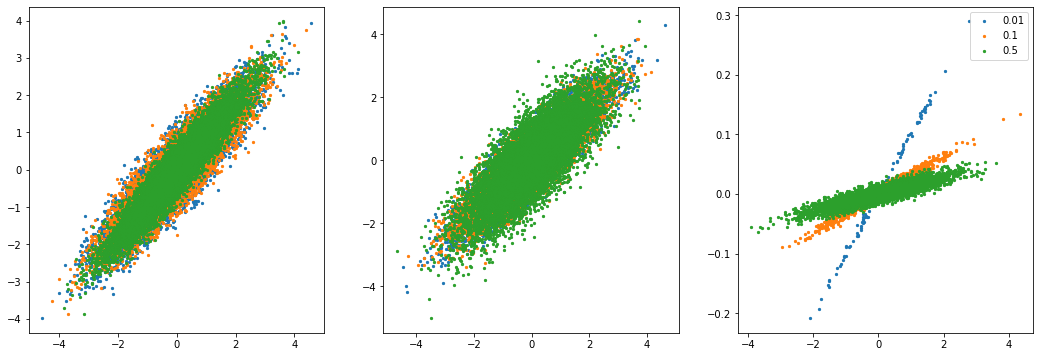

In [ ]:
plot_results(experiments)

In [ ]:

for key,val in experiments.items():
  theta_tilde, theta, Y_train_tilde, Y_train, Y_test_tilde, Y_test = val 
  print('alpha = {alpha}, sigma = {sigma}'.format(alpha = key.alpha, sigma = key.sigma))
  p = np.polyfit(np.ravel(Y_train), np.ravel(Y_train_tilde), 1)
  print('test RMSE: {rmse}, slope: {slope}'.format(rmse = mean_squared_error(Y_train_tilde,Y_train, squared = False), slope = p[0]))
  p = np.polyfit(np.ravel(Y_test), np.ravel(Y_test_tilde), 1)
  print('test RMSE: {rmse}, slope: {slope}'.format(rmse = mean_squared_error(Y_test_tilde,Y_test, squared = False), slope = p[0]))
  print()


alpha = 0.01, sigma = 0.5
test RMSE: 0.5003135564333773, slope: 0.8098926345591086
test RMSE: 0.5008163792892595, slope: 0.8106191854013265

alpha = 0.1, sigma = 0.5
test RMSE: 0.47660313074915917, slope: 0.8124614609038614
test RMSE: 0.5299597914042018, slope: 0.7904664693885903

alpha = 0.5, sigma = 0.5
test RMSE: 0.35332240487468164, slope: 0.8988169892805016
test RMSE: 0.7098192457809049, slope: 0.7865934883697777



# Diving in the theory: how do we diagnose overfitting?

## Fitting and overfitting: MAP

Before looking at overfitting, let's first ask how models are fit. The two cases looked at here are Maximum A Posteriori estimation (MAP) and maximum likelihood (ML), which are basically the same except MAP include a prior. We'll look at the MAP case since it's easy to recover the ML case from it.

The idea is that given an empirical set of observations $\cal{D} = \{(\mathbf{z}_1, s_1),(\mathbf{z}_2, s_2),\cdots\}$ where $\mathbf{z}$ are observed feature vectors and $s$ are target variables, the joint probability $P(\cal{D},\mathbf{\theta})$ is given by 
$$
P(\cal{D},\mathbf{\theta}) = 
P(\mathbf{\theta})\prod_{i=1}^{N}
P(s_i|\mathbf{z}_i, \mathbf{\theta})P(\mathbf{z}_i)
$$
and thus the posterior probability $P(\theta|\cal{D})$ is, up to an eventual normalization factor
$$
P(\theta|\cal{D}) \propto P(\mathbf{\theta}) \prod_{i=1}^{N}
P(s_i|\mathbf{z}_i, \mathbf{\theta})
$$
which, in logarithmic form and up to a constant, gives
$$
\begin{align}
\frac{1}{N}\log 
P(\theta|\cal{D}) =& \frac{1}{N}\log P(\mathbf{\theta})  + \frac{1}{N}\sum_i
\log P(s_i|\mathbf{z}_i, \mathbf{\theta})
\\=&
\frac{1}{N}\log P(\mathbf{\theta})  + \int
\hat{P}(s,\mathbf{z}|\cal{D})\log P(s|\mathbf{z}, \mathbf{\theta}) \,d\mathbf{z}  ds
\end{align}
$$
where 
$$
\hat{P}(s,\mathbf{z}|\cal{D}) = \frac{1}{N}\sum_i\delta(\mathbf{z} - \mathbf{z}_i)\delta(s - s_i)
$$
is the empirical joint distribution of $\mathbf{z}$ and $s$.
This expression can then be rewritten as 
$$
\begin{align}
-\frac{1}{N}\log 
P(\theta|\cal{D}) =&
-\frac{1}{N}\log P(\mathbf{\theta})  + D_{KL}(\hat{P}(s,\mathbf{z}|\cal{D})||P(s|\mathbf{z}, \mathbf{\theta})) - \int
\hat{P}(s,\mathbf{z}|\cal{D})\log \hat{P}(s,\mathbf{z}|\cal{D}) \,d\mathbf{z}  ds
\\=&
-\frac{1}{N}\log P(\mathbf{\theta}) 
+ D_{KL}(\hat{P}(s,\mathbf{z}|\cal{D})||P(s|\mathbf{z}, \mathbf{\theta})) 
+\cal{H}(t|\mathbf{z},\cal{D})
\end{align}
$$

where 

$$
\cal{H}(t|\mathbf{z},\cal{D}) = - \int
\hat{P}(s,\mathbf{z}|\cal{D})\log \hat{P}(s,\mathbf{z}|\cal{D}) \,d\mathbf{z} 
$$
is called the differential Shannon entropy of the empirical conditional distribution $\hat{P}(s,\mathbf{z}|\cal{D})$, and 
$$
D_{KL}(p||q) 
= 
\int
p(\mathbf{x})\log \frac{p(\mathbf{x})}{q(\mathbf{x})} \,d\mathbf{x}
$$
is the Kullback-Leibler divergence of p and q.

The MAP principle then states that the best choice of parameters $\theta$ is the one that maximizes $P(\theta|\cal{D})$, or equivalently minimizes the expression above (and therefore, in the ML case, minimizes the Kullback-Leibler divergence between the empirical and modelled distribution).




### Small aside: Let's see what a Kullbach-Leibler divergence looks like in the wild

And while we're at it we'll add the Jensen-Shannon divergence as well, which is a symmetrized form of the KL divergence.

In [75]:

import numpy as np
KL = lambda x,y: np.sum(x*np.log(x/y))
JS = lambda x,y: (KL(x,(x+y)/2) + KL(y,(x+y)/2))/2

def gaussian_divergence(mu, sigma, N = int(1e4), n = int(1e2), type_ = 'KL'):
  assert type_ in ['KL','JS']
  x0, x1 = np.random.randn(N), mu + sigma*np.random.randn(N)

  bins = np.linspace(np.minimum(x0.min(), x1.min()), np.maximum(x0.max(), x1.max()),n, endpoint=True)
  x0_binned, x1_binned =  np.digitize(x0,bins),np.digitize(x1,bins)
  p0 = np.zeros(n)
  p1 = np.zeros(n)
  for i in range(1,n+1):
    p0[i-1] = np.sum(x0_binned==i)
    p1[i-1] = np.sum(x1_binned==i)
  p0,p1 = np.maximum(p0/N,1e-60), np.maximum(p1/N,1e-60)
  if type_ == 'KL':
    return KL(p0,p1)
  elif type_=='JS':
    return JS(p0,p1)

In [76]:
n_tries = 1000
results = np.zeros((n_tries,6))
for j in range(n_tries):
  results[j,0] = gaussian_divergence(0,1)
  results[j,1] = gaussian_divergence(0,1.5)
  results[j,2] = gaussian_divergence(.5,1)
  results[j,3] = gaussian_divergence(0,1, type_ = 'JS')
  results[j,4] = gaussian_divergence(0,1.5, type_ = 'JS')
  results[j,5] = gaussian_divergence(.5,1, type_ = 'JS')
  

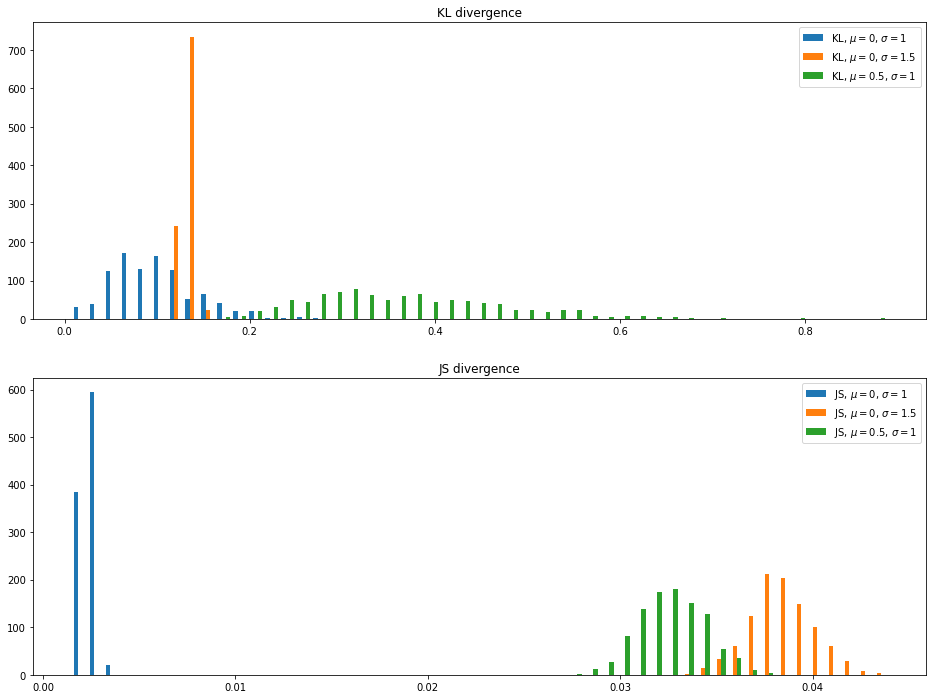

In [86]:
fig, ax = plt.subplots(2,figsize = (16,12))
ax[0].hist(results[:,:3], bins=51);
ax[0].legend(['KL, $\mu = 0$, $\sigma = 1$', 'KL, $\mu = 0$, $\sigma = 1.5$', 'KL, $\mu = 0.5$, $\sigma = 1$']);
ax[0].set_title('KL divergence');
ax[1].hist(results[:,3:], bins=51);
ax[1].legend(['JS, $\mu = 0$, $\sigma = 1$', 'JS, $\mu = 0$, $\sigma = 1.5$', 'JS, $\mu = 0.5$, $\sigma = 1$']);
ax[1].set_title('JS divergence');




## Overfitting

In deep learning, or in models that are trained over long periods of time generally, overfitting can be pretty easy to spot in simple cases: train your model, test at each epoch on a separate validation dataset, and the moment your validation loss starts to increase is when you start overfitting. 
And generally speaking, a measure of overfitting is the difference between training and validation loss. From a theoretical standpoint, how does this translate?

Well, suppose you have no model mismatch, meaning that there is a choice of parameters such that given infinite data, the model throws you exactly the observed distribution of outcomes. This is not the same as saying that for any *finite* sample the model is the best fit: there is a gap between this theoretical, infinite distribution of outcomes and the empirical distribution observed on a finite sample, meaning in turn that there can be a set of parameters that yields a model distribution "closer" to the empirical distribution. 

This means there's no way to avoid overfitting by blind minimizing of a loss function, though different loss functions will presumably behave differently. Intuitively, the better the loss function reflects the underlying geometry of the distribution space the better the results will be, and it's worth spending a minute to wonder why the Kullback-Leilber divergence does a good job in that sense. I have absolutely no intention of going down that particular rabbit hole however, and direct the reader towards Shunichi Amari's [Information Geometry and its applications](https://www.springer.com/gp/book/9784431559771), in which we can find a form of weak justification for the use of KL divergence as a measure of dissimilarity in the form of e.g. theorem 3.2.

<!-- ## Closer and closer: distance and probability distributions
In the paper, the metric use for closeness is the Kullback-Leibler divergence. It's a standard measure of proximity for probability distributions, though it has a few issues such as the fact that it is not symmetric, nor does it obey the triangle inequality.

The question of what *is* a good metric for probability distributions is not obvious, and a digression would take us down a rich and deep rabbit hole with a fair amount of optimal transport theory and differential geometry involved (e.g. a bit of googling leads one to things like the Fisher-Rao information metric, which is indeed a distance but which is difficult to compute as show in https://www.mdpi.com/1099-4300/22/4/404/htm). For now, I'll direct the reader to Amari's Information Geometry and its applications, in which we can find a form of justification for the use of KL divergence as a measure of dissimilarity in the form of theorem 3.2, which states that the symmetrized KL divergence is equal to the integral of the Fisher information metric over two different types of curves (including linear interpolation). -->
<!-- https://www.mdpi.com/1099-4300/22/4/404/htm -->


## MAP overfitting and statistical physics

Since we are concerned only with finding the right parameters $\theta$, the MAP minimization simplifies to finding the minimum of
$$
E(\theta|{\cal{D}}) = -\frac{1}{N}\log P(\mathbf{\theta}) 
+ D_{KL}(\hat{P}(s,\mathbf{z}|\cal{D})||P(s|\mathbf{z}, \mathbf{\theta}))
$$
More specifically, we're not really interested in the minimum of a particular configuration, but we're more interested in the moments of this quantity, i.e.
$$
\left\langle
E^n(\theta|{\cal{D}})
\right\rangle_{{\cal{D}}}
$$
In this formulation, those readers familiar with probability theory will start thinking "moment generating function", or even "cumulant generating function", and indeed we're getting there.

Now the problem above is actually a pretty common problem in statistical physics, since it maps to finding the ground state of a system with Hamiltonian
$$
H(\theta) =  \frac{1}{N}\log P(\mathbf{\theta}) + \frac{1}{N}\sum_i
\log P(s_i|\mathbf{z}_i, \mathbf{\theta})
$$
Incidentally, since we know that the samples are drawn from a distribution with true parameters $\theta^*$, we can rewrite this as 
$$
H(\theta|\theta^*) =  \frac{1}{N}\log \frac{P(\mathbf{\theta})}{P(\theta^*)} + \frac{1}{N}\sum_i
\log \frac{P(s_i|\mathbf{z}_i, \mathbf{\theta})}{P(s_i|\mathbf{z}_i, \mathbf{\theta^*})}
$$
since the difference is only a constant, and it has the advantage that at the true parameters, $H(\theta^*|\theta^*) = 0$ (i.e. we have overfitting if $H(\theta^*|\theta^*)<0$).


## Replica method

To solve this statistical physics problem, the usual method is called the replica methods, which can be likened to an annealing process on hallucinogens: we consider
$$
\begin{align}
Z_\beta(\cal{D})
=& -\frac{1}{\beta}\log \int d\theta\,e^{-\beta H(\theta|\theta^*)}
\\
\mathrm{and}\quad F_\beta(\cal{D}) 
  =& -\frac{1}{\beta}\log Z_\beta(\cal{D})
\end{align}
$$
(I did mention we'd get to the cumulant generating function eventually).
Since $F_\beta(\cal{D})$ is more or less the cumulant generating function of $H$, we now want to compute
$$
F(\beta) = 
\left\langle
F_\beta(\cal{D})
\right\rangle_{\cal{D}}
$$ 

You'll notice that this expression involves computing the average of a log, which is rarely pleasant. That's where the replica trick comes in. We write
$$
\begin{align}
F(\beta) = &
\lim_{n\rightarrow 0}
\left\langle
\frac{Z_\beta^n({\cal{D}})-1}{n}
\right\rangle_{\cal{D}}
\\=&
\lim_{n\rightarrow 0}
\frac{
  \left\langle Z_\beta^n({\cal{D}})\right\rangle_{\cal{D}}
-1}{n}
\quad\text{(that's the annealing part)}
\end{align}
$$
and we then compute this average for integer $n$ before taking the limit $n\rightarrow 0$ (that's the hallucinogenics part).

The exact argument for why this works involves a lot of embarassed noises by physics teachers with mutterings of "analytic continuation" intersped with "but the results are confirmed by the cavity method" and we won't go into it. The point is that we now focus on computing 
$
\left\langle Z_\beta^n({\cal{D}})\right\rangle_{\cal{D}}
$. 